### Part 1: Import recource & Hyperparameter

In [1]:
# Comman library
import math
import random
import numpy as np
import gym
from gym import spaces
import cv2
from collections import deque

In [2]:
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import torchvision

In [3]:
# Tool for image preprocessing
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Device and variable for parameter transferring
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if torch.cuda.is_available() else autograd.Variable(*args, **kwargs)

cpu


In [5]:
# Hyper-parameter
BATCH_SIZE = 32         # Minibatch size 
GAMMA = 0.99            # Discount factor 
LR = 1e-5               # Learning rate
UPDATE_TARGET = 1000    # How often to update the target-network
NUM_FRAME = 30000 

In [6]:
# Memory-parameter
BUFFER_SIZE = int(1e5)  # Replay buffer size 
REPLAY_INITIAL = 100    # Random sampling period

In [7]:
# Epsilon
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 500

EPS_BY_FRAME = lambda frame_idx : EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx / EPS_DECAY)

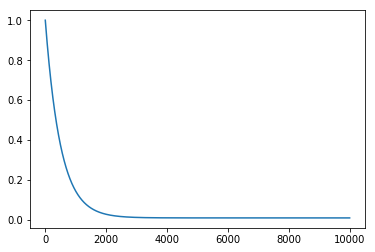

In [8]:
# Plot changing epsilon
plt.plot([EPS_BY_FRAME(i) for i in range(10000)])

In [9]:
# Tensor board
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/dqn_cartpole')

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

---
### Part 2: Image preprocessing & DQN

In [10]:
env_id = "CartPole-v0"
env    = gym.make(env_id)

In [11]:
# Environment-parameter
num_input = env.observation_space.shape[0]
print(num_input)
num_action  = env.action_space.n
print(num_action)

4
2


In [12]:
class DQN(nn.Module):
    def __init__(self, num_input, num_action):
        super(DQN, self).__init__()

        self.num_input = num_input
        self.num_action = num_action

        self.l1 = nn.Linear(num_input, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, num_action)
    
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        
        return x

In [13]:
# Generate Q-network
if torch.cuda.is_available():
    model = DQN(num_input, num_action).cuda()
else:
    model = DQN(num_input, num_action)
    
optimizer = optim.Adam(model.parameters())

---
### Part 3: Replay memory

In [14]:
class Memory(object):
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        
    
    def add(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.memory.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.memory)

---
### Part 4: Agent

In [15]:
class Agent:
  
    def __init__(self, num_input, num_action):
        """Initialize an Agent object.
          
          Params
          ======
              num_input: dimension of each state
              num_action: dimension of each action
          """
        self.num_input = num_input
        self.num_action = num_action

        self.memory = Memory(BUFFER_SIZE, BATCH_SIZE)
 
    def step(self, batch_size, gamma):
        """Change current frame to next one and get loss."""
        # Learn DQN and return loss
        if len(self.memory) >= REPLAY_INITIAL:
            loss = self.dqn_loss(BATCH_SIZE, GAMMA)
            losses.append(loss.item())    
        else:
            pass

    def dqn_loss(self, batch_size, gamma):
        """Calculate loss using DQN"""
        state, action, reward, next_state, done = self.memory.sample(batch_size)

        state      = Variable(torch.FloatTensor(np.float32(state)))
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
        action     = Variable(torch.LongTensor(action))
        reward     = Variable(torch.FloatTensor(reward))
        done       = Variable(torch.FloatTensor(done))

        # DQN
        q_values      = model(state)
        next_q_values = model(next_state)
    
        q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value     = next_q_values.max(1)[0]
        expected_q_value = reward + gamma * next_q_value * (1 - done)
        
        loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        writer.add_scalar('Train/Loss', loss, frame_idx)    # --> Tensor board
        
        return loss
    
    def act(self, state, eps):
        if random.random() > eps:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = model.forward(state)   
            action = q_value.max(1)[1].item() 

        else:
            action = random.randrange(env.action_space.n)

        return action

---
### Part 5: Plot


In [16]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Frame %s. Reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('Loss')
    plt.plot(losses)
    plt.show()

---
### Part 6: Training

In [17]:
agent = Agent(num_input=num_input, num_action=num_action)

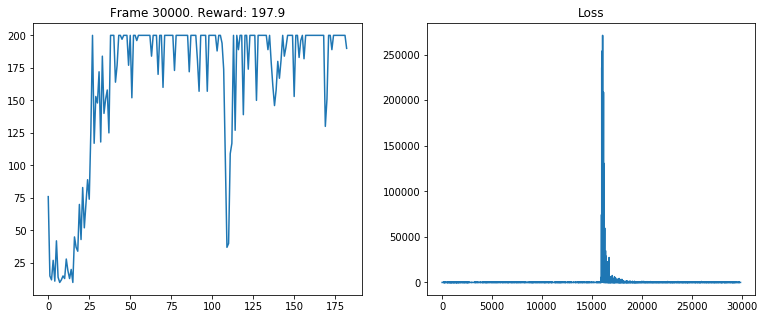

In [18]:
losses = []
all_rewards = []
episode_reward = 0


state = env.reset()
for frame_idx in range(1, NUM_FRAME + 1):
    # Epsilon
    eps = EPS_BY_FRAME(frame_idx)
    # Act
    action = agent.act(state, eps)
    # Get next experience
    next_state, reward, done, _ = env.step(action)
    # Put experience into memory
    agent.memory.add(state, action, reward, next_state, done)
    # Update state and reward
    state = next_state
    episode_reward += reward
    # Calculate loss
    loss = agent.step(BATCH_SIZE, GAMMA)

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        writer.add_scalar('Train/Reward', episode_reward, frame_idx)    # --> Tensor board
        episode_reward = 0
        
    if frame_idx % 1000 == 0:
        plot(frame_idx, all_rewards, losses)
        

In [19]:
writer.close()